In [4]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nadirkhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
class SentimentClassifier:
    
    def __init__(self, filename):
        self.filename = filename
        self.data = None
        self.vectorizer = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_yelp_data(self, use_chunk=True):
        """
        """
        if use_chunk:
            yelp_data = pd.read_json(self.filename, lines=True, chunksize=100000)
            for chunk in yelp_data:
                yelp_sample = chunk.copy()  # create a copy of the chunk to modify
                yelp_sample['length'] = yelp_sample['text'].apply(len)
                yelp_sample['stars'] = yelp_sample['stars'].astype(float)
                result = yelp_sample.to_json(orient="records")
                with open("yelp_sample.json", "w") as f:
                    json.dump(result, f)
                self.data = yelp_sample
                print("yelp data chunk:", self.data)
                print("Shape of the dataset:", yelp_sample.shape)
                break
        else:
            yelp_sample = pd.read_json(self.filename, lines=True)
        yelp_sample['length'] = yelp_sample['text'].apply(len)
        yelp_sample['stars'] = yelp_sample['stars'].astype(float)
        result = yelp_sample.to_json(orient="records")
        with open("yelp_sample.json", "w") as f:
            json.dump(result, f)
        self.data = yelp_sample
            
    def analyze_review_voting_types(self):
        """
        """
        yelp_groupby = self.data.loc[:, ['stars', 'useful', 'funny', 'cool', 'length']]
        star_vote = yelp_groupby.groupby(by='stars').mean()
        count = self.data['stars'].value_counts().sort_index(ascending=False)

        print()
        print("Star rating by review voting types:")
        print(star_vote)

        print()
        print("Correlation between review voting types:")
        print(star_vote.corr())

        print()
        print("Star count")
        print(count)
    
    def plot_review_length_histograms(self):
        """
        """
        graph = sns.FacetGrid(data=self.data, col='stars')
        graph.map(plt.hist, 'length', bins=50, color='blue')
        plt.show()
    
    def classify_data(self, text_column='text'):
        """
        """
        yelp_classify = self.data.loc[:, ['stars', text_column]]
        data_classes = yelp_classify[(yelp_classify['stars'] == 1) |
                                     (yelp_classify['stars'] == 2) |
                                     (yelp_classify['stars'] == 3) | 
                                     (yelp_classify['stars'] == 4) |
                                     (yelp_classify['stars'] == 5)]
        self.X = data_classes[text_column]
        self.y = data_classes['stars']


        print()
        print("Shape of the dataset:", data_classes.shape)

        x = data_classes[text_column]
        y = data_classes['stars']

        print()
        print("A few X entries")
        print(x.head())

        print()
        print("A few Y entries")
        print(y.head())

        return x, y
    
    def process_text(self, text):
        """
        """
        nopunc = [char for char in text if char not in string.punctuation]
        nopunc = ''.join(nopunc)
        return [word.lower() for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    def get_vocab(self):
        """
        """
        if self.data is None:
            print("Error: data not loaded")
            return None
        
        self.vectorizer = CountVectorizer(analyzer=self.process_text).fit(self.data['text'])
#         self.vectorizer = CountVectorizer(analyzer=self.process_text).fit(x)
        return self.vectorizer
    
    def create_training_and_testing_sets(self, x, y):
        """
        """
       
        self.vectorizer = self.get_vocab()
        x = self.vectorizer.transform(x)
        x_classes = x[(y == 1) | (y == 2) |(y == 3) |(y == 4) | (y == 5)]
        y_classes = y[(y == 1) | (y == 2) |(y == 3) | (y == 4) | (y == 5)]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(x_classes, y_classes, test_size=0.2, random_state=101, stratify=y)

    def multinomial_naive_bayes(self):
        """
        """
        mnb = MultinomialNB()
        mnb.fit(self.X_train, self.y_train)
        pred = mnb.predict(self.X_test)

        print()
        print("Multinomial Naive Bayes Score:", round(accuracy_score(self.y_test, pred) * 100, 2))

        print()
        print("Classification Report:")
        print(classification_report(self.y_test, pred))
    
    def random_forest(self):
        """
        """       
        rmfr = RandomForestClassifier()
        rmfr.fit(self.X_train, self.y_train)
        predrmfr = rmfr.predict(self.X_test)

        print()
        print("Score:", round(accuracy_score(self.y_test, predrmfr) * 100, 2))

        print()
        print("Classification Report:")
        print(classification_report(self.y_test, predrmfr))
    
    def decision_tree(self):
        """
        Trains and evaluates a decision tree classifier on the Yelp review data
        """        
        dt = DecisionTreeClassifier()
        dt.fit(self.X_train, self.y_train)
        preddt = dt.predict(self.X_test)

        print()
        print("Score:",round(accuracy_score(self.y_test, preddt) * 100, 2))

        print()
        print("Classification Report:")
        print(classification_report(self.y_test, preddt)) 
        
#Run each model in sequence to get different accuracy scores depending on tuning of hyperparameters
    
    def nnl_classifier(self, regularization_rate=0.01, learning_rate=0.001, layer_sizes=(100,), num_layers=1):
        """
        """
        clf = MLPClassifier(
        random_state=101,
        max_iter=200,
        alpha=regularization_rate,
        learning_rate_init=learning_rate,
        hidden_layer_sizes=layer_sizes * num_layers
        )

        clf.fit(self.X_train, self.y_train)
        clfpredict = clf.predict(self.X_test)
        
        print()
        print("Score:",round(accuracy_score(self.y_test, clfpredict) * 100, 2))

        print()
        print("Classification Report NNL:")
        print(classification_report(self.y_test, clfpredict)) 
    
#     def nnl_classifier(self, regularization_rate=0.1, learning_rate=0.01, layer_sizes=(100,), num_layers=5):
#         """
#         """
#         clf = MLPClassifier(
#         random_state=101,
#         max_iter=200,
#         alpha=regularization_rate,
#         learning_rate_init=learning_rate,
#         hidden_layer_sizes=layer_sizes * num_layers
#         )

#         clf.fit(self.X_train, self.y_train)
#         clfpredict = clf.predict(self.X_test)
        
#         print()
#         print("Score:",round(accuracy_score(self.y_test, clfpredict) * 100, 2))

#         print()
#         print("Classification Report NNL:")
#         print(classification_report(self.y_test, clfpredict)) 
        
#     def nnl_classifier(self, regularization_rate=0.1, learning_rate=1, layer_sizes=(10,), num_layers=10):
#         """
#         """
#         clf = MLPClassifier(
#         random_state=101,
#         max_iter=200,
#         alpha=regularization_rate,
#         learning_rate_init=learning_rate,
#         hidden_layer_sizes=layer_sizes * num_layers
#         )

#         clf.fit(self.X_train, self.y_train)
#         clfpredict = clf.predict(self.X_test)
        
#         print()
#         print("Score:",round(accuracy_score(self.y_test, clfpredict) * 100, 2))

#         print()
#         print("Classification Report NNL:")
#         print(classification_report(self.y_test, clfpredict)) 
        
        

yelp data chunk:                     review_id                 user_id             business_id  \
0      KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1      BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2      saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3      AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4      Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   
...                       ...                     ...                     ...   
99995  pAEbIxvr6ebx2bHc1XvguA  SMH5CeiLvKx61lKwtLZ_PA  lV0k3BnslFRkuWD_kbKd0Q   
99996  xH1AoE-4nf2ECGQJRjO4_g  2clTdtp-BjphxLjN83CpUA  G0xz3kyRhRi6oZl7KfR0pA   
99997  GatIbXTz-WDru5emONUSIg  MRrN6DH3QGCFcDv5RENYVg  C4lZdhasjZVQyDlOiXY1sA   
99998  6NfkodAdhvI89xONXuBC3A  rnNQzeKJbvqVCsYsL10mkQ  dChRGpit9fM_kZK5pafNyA   
99999  sJ1BMq7lkKgOWEFx3n6ZRw  _BcWyKQL16ndpBdggh2kNA  hMcgO98QaOFmQVTfCUeGzw   

       sta

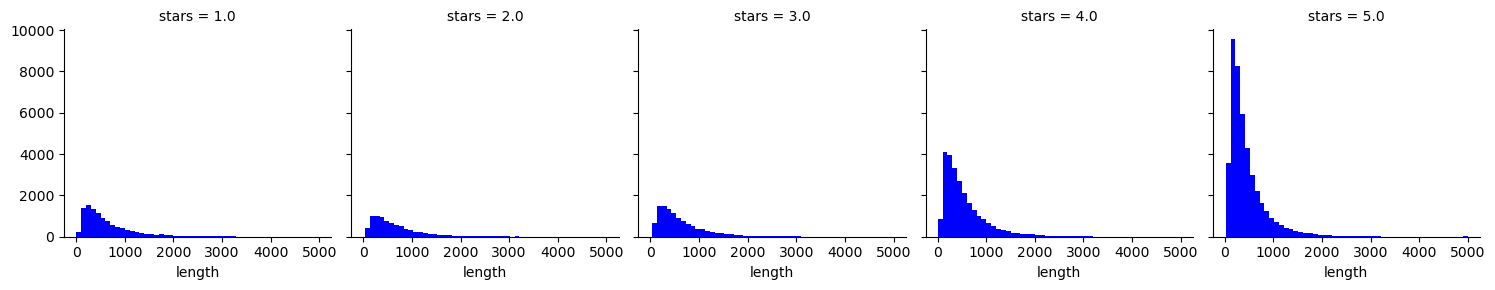


Shape of the dataset: (100000, 2)

A few X entries
0    If you decide to eat here, just be aware it is...
1    I've taken a lot of spin classes over the year...
2    Family diner. Had the buffet. Eclectic assortm...
3    Wow!  Yummy, different,  delicious.   Our favo...
4    Cute interior and owner (?) gave us tour of up...
Name: text, dtype: object

A few Y entries
0    3.0
1    5.0
2    3.0
3    5.0
4    4.0
Name: stars, dtype: float64

Number of possible words: 101943

Sample Uncleaned Review:
I've taken a lot of spin classes over the years, and nothing compares to the classes at Body Cycle. From the nice, clean space and amazing bikes, to the welcoming and motivating instructors, every class is a top notch work out.

For anyone who struggles to fit workouts in, the online scheduling system makes it easy to plan ahead (and there's no need to line up way in advanced like many gyms make you do).

There is no way I can write this review without giving Russell, the owner of Body Cycle,

In [26]:
#Run it in sequence
# classifier = SentimentClassifier('/Users/rsurridge/Downloads/yelp_data/yelp_academic_dataset_review.json')
classifier = SentimentClassifier('/Users/nadirkhan/Desktop/Spring Quarter/ML/Group Project/github-repo/yelp_dataset/yelp_academic_dataset_review.json')
classifier.load_yelp_data(use_chunk=True)
classifier.analyze_review_voting_types()
classifier.plot_review_length_histograms()
x, y = classifier.classify_data()

# preprocessed_text = classifier.process_text(text)
vocab = classifier.get_vocab()
##To check a sample of data vectorized
r1 = classifier.data['text'][1]
vocab1 = vocab.transform([r1])
print()
print("Number of possible words:", len(vocab.vocabulary_))

print()
print("Sample Uncleaned Review:")
print(r1)

print()
print("Vectorized Review:")
print(vocab1)

print()
print("Return word from index 5000:", vocab.get_feature_names_out()[5000])
print("Return word from index 20000:", vocab.get_feature_names_out()[20000])

classifier.create_training_and_testing_sets(x, y)
# classifier.multinomial_naive_bayes()
# classifier.random_forest()
# classifier.decision_tree()
classifier.nnl_classifier()
